<a href="https://www.kaggle.com/code/sarthakkapaliya/dogemotionrecognition?scriptVersionId=129949001" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Name: Sarthak Kapaliya
# Roll No: 20BCP072
# Date: 17/5/2023
# Subject: Techdome Final Assessment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# This Notebook Contains Source Code For making an EfficientNet Models

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories Informations
DIRECTORY = r'/kaggle/input/dog-emotions-prediction/images'
OUT_DIR = r'/kaggle/working/'
# Classes
CATEGORIES = ["angry", "happy", "relaxed", "sad"]
# Making new folders for training and testing Data

TRAIN_DIR = os.path.join(OUT_DIR, "train")
TEST_DIR = os.path.join(OUT_DIR, "test")
# Create train and test directories
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Move images to train and test directories
for category in CATEGORIES:
    image_dir = os.path.join(DIRECTORY, category)
    train_category_dir = os.path.join(TRAIN_DIR, category)
    test_category_dir = os.path.join(TEST_DIR, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)
    images = os.listdir(image_dir)
    n_test_images = int(len(images) * 0.2)  # 20% of images go to test
    test_images = images[:n_test_images]
    train_images = images[n_test_images:]
    for image in train_images:
        src = os.path.join(image_dir, image)
        dst = os.path.join(train_category_dir, image)
        shutil.copy(src, dst)
    for image in test_images:
        src = os.path.join(image_dir, image)
        dst = os.path.join(test_category_dir, image)
        shutil.copy(src, dst)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Augmenting the Training Data and applying various augmentation using Keras ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                     
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/working/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 10192 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/kaggle/working/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 2547 images belonging to 4 classes.


In [6]:
test_dataset = test_datagen.flow_from_directory(directory = '/kaggle/working/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 3182 images belonging to 4 classes.


# Applying EfficientNet

In [7]:
import cv2
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [8]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [9]:
import efficientnet.keras as efn
base_model = efn.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling=None,
    classes=4)

16804768/16804768 [==============================] - 0s 0us/step


In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
import tensorflow as tf
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 batch_normalization (BatchN  (None, 62720)            250880    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                2007072   
                                                                 
 batch_normalization_1 (Batc  (None, 32)               1

In [13]:
# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

In [14]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [15]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 25 ,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/25


2023-05-17 16:24:16.532522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


160/160 [==============================] - 159s 879ms/step - loss: 1.2947 - accuracy: 0.7529 - precision: 0.5165 - recall: 0.1826 - auc: 0.6786 - val_loss: 1.2431 - val_accuracy: 0.7601 - val_precision: 0.5363 - val_recall: 0.2984 - val_auc: 0.7214 - lr: 0.0010
Epoch 2/25
160/160 [==============================] - 139s 866ms/step - loss: 1.2016 - accuracy: 0.7674 - precision: 0.5878 - recall: 0.2324 - auc: 0.7291 - val_loss: 1.2056 - val_accuracy: 0.7671 - val_precision: 0.5679 - val_recall: 0.2858 - val_auc: 0.7336 - lr: 0.0010
Epoch 3/25
160/160 [==============================] - 138s 860ms/step - loss: 1.1750 - accuracy: 0.7731 - precision: 0.6098 - recall: 0.2564 - auc: 0.7437 - val_loss: 1.1774 - val_accuracy: 0.7730 - val_precision: 0.5893 - val_recall: 0.3031 - val_auc: 0.7455 - lr: 0.0010
Epoch 4/25
160/160 [==============================] - 136s 851ms/step - loss: 1.1622 - accuracy: 0.7772 - precision: 0.6242 - recall: 0.2730 - auc: 0.7506 - val_loss: 1.1720 - val_accuracy: 0.

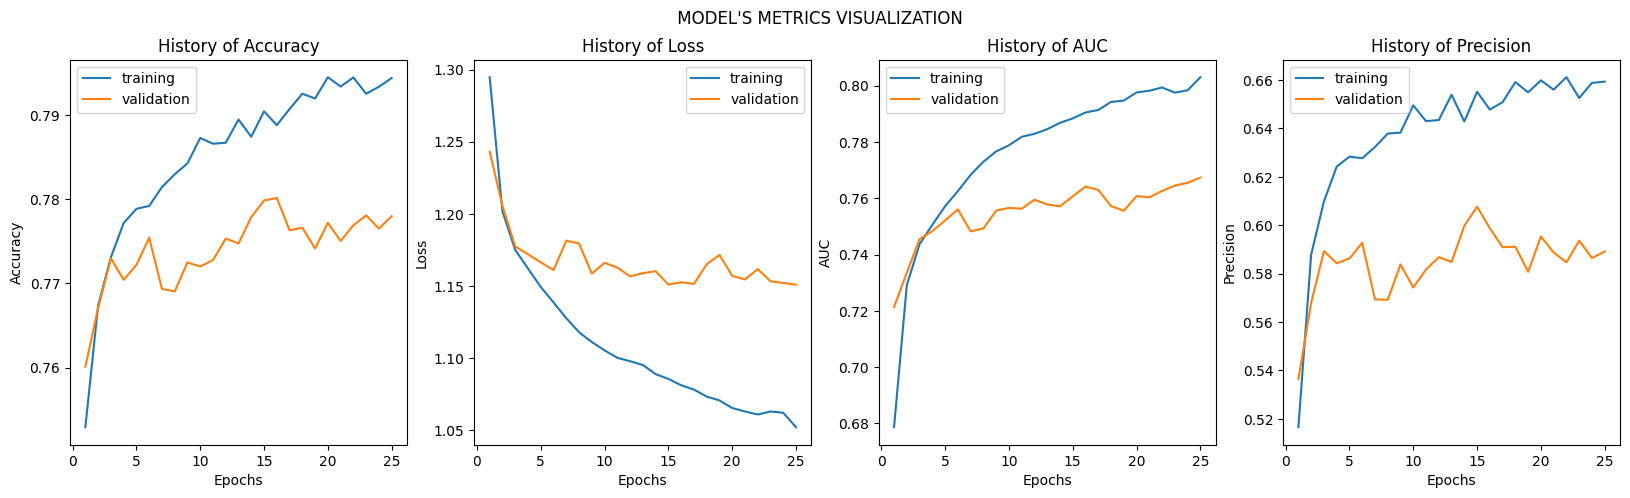

In [16]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
#                history.history['f1_score'],history.history['val_f1_score']
              )

In [17]:
prediction = model.evaluate(test_dataset)

50/50 [==============================] - 11s 215ms/step - loss: 1.1378 - accuracy: 0.7833 - precision: 0.6045 - recall: 0.3853 - auc: 0.7731


## Results:

### We have used EfficientNet Model For Prediction of Dog Emotion Recognition which is a Multiclass Classification having 4 classes 

#### { Angry , Sad , Happy , Relaxed }


In [18]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Load the pre-trained model
model = load_model("/kaggle/working/model.h5")


# Evaluate the model on the test data
loss, accuracy,precision,recall,auc = model.evaluate(test_dataset)
print("######################################################################################")
print("######################################################################################")
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:",precision)
print("Test Recall:",recall)
print("Test AUC",auc)
print("######################################################################################")
print("######################################################################################")


# Predict on the test data
predictions = model.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)

# Print the predicted classes
print("Predicted Classes:", predicted_classes)


50/50 [==============================] - 11s 195ms/step - loss: 1.1378 - accuracy: 0.7833 - precision: 0.6045 - recall: 0.3853 - auc: 0.7731
######################################################################################
######################################################################################
Test Loss: 1.137755274772644
Test Accuracy: 0.7833123803138733
Test Precision: 0.6045364737510681
Test Recall: 0.38529226183891296
Test AUC 0.7731184959411621
######################################################################################
######################################################################################
50/50 [==============================] - 12s 205ms/step
Predicted Classes: tf.Tensor([2 2 3 ... 3 3 2], shape=(3182,), dtype=int64)


In [19]:
predicted_values = tf.argmax(predictions, axis=1)
category_names = ["angry", "happy", "relaxed", "sad"] 
predicted_categories = [category_names[value] for value in predicted_values]
# Initial
print(predicted_categories[:6])

['relaxed', 'relaxed', 'sad', 'relaxed', 'sad', 'relaxed']
